# TreppWire-Powered AI assistant

* **This chatbot has been trained to understand historical credit stories using a Retrieval-Augmented Generation (RAG) model.**

* **Currently, it can answer questions related to previous property information found in past credit stories.** 

* **This capability helps our company analysts quickly refer to historical information when writing new articles. Additionally, it enhances clients' efficiency in finding information, especially when they are busy and need specific details promptly.**

<!-- 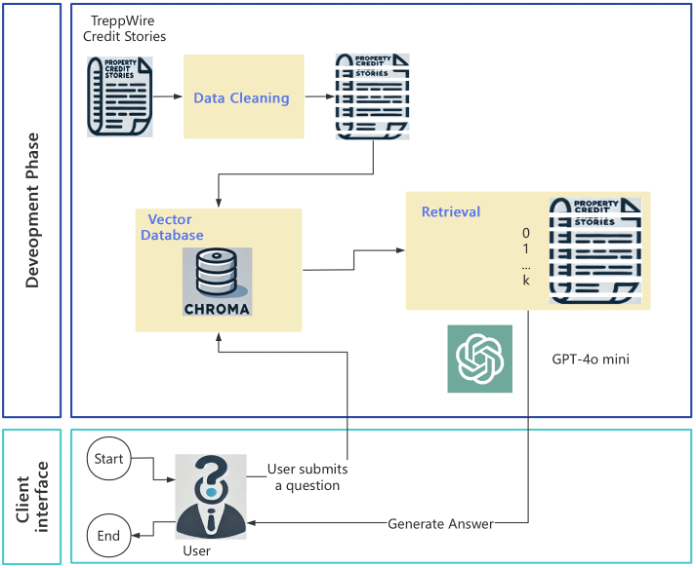 -->
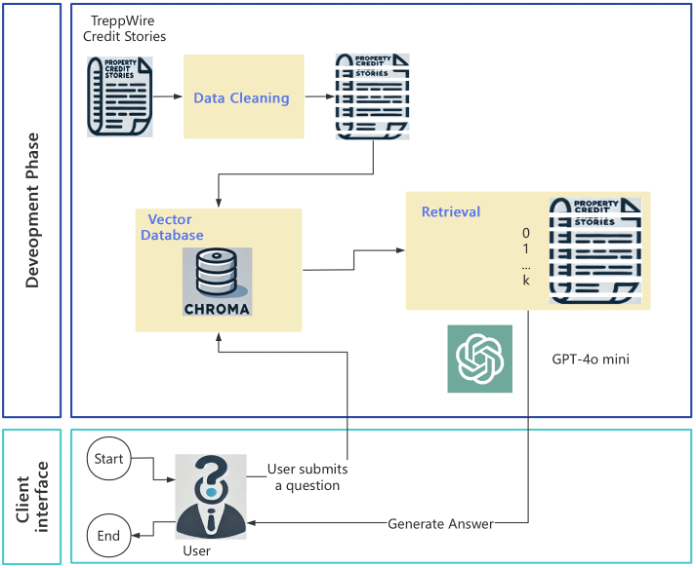

### RAG Code

In [1]:
import math, random, os, re, time, json
from datetime import date, datetime
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm


import openai, tiktoken
from openai import OpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
import faiss

import boto3
from pyathena import connect
import pyarrow.parquet as pq
from botocore.exceptions import ClientError

%matplotlib inline
sns.set_theme()

Matplotlib is building the font cache; this may take a moment.


In [2]:
class SecretManager:
    def __init__(self, secret_name, region_name="us-east-1"):
        self.secret_name = secret_name
        self.region_name = region_name
        self.client = boto3.session.Session().client(
            service_name='secretsmanager', 
            region_name=region_name
        )
        
    def get_secret(self, api_key_name):
        try:
            get_secret_value_response = self.client.get_secret_value(
                SecretId=self.secret_name
            )
        except ClientError as e:
            # For a list of exceptions thrown, see
            # https://docs.aws.amazon.com/secretsmanager/latest/apireference/API_GetSecretValue.html
            raise e

        secret = get_secret_value_response['SecretString']

        return json.loads(secret)[api_key_name]
    
    

class S3ParquetLoader:
    def __init__(self, bucket_name, prefix, file_identifier="s3://"):
        self.bucket_name = bucket_name
        self.prefix = prefix
        self.file_identifier = file_identifier
        
    def load_s3_parquet(self, file):
        s3_path = self.file_identifier + self.bucket_name + self.prefix + file
        return pq.read_table(s3_path).to_pandas()

    
class OpenAIClient:
    def __init__(self, model='gpt-4o-mini', seed=12345, temperature=0, tools=None):
        self.model = model
        self.seed = seed
        self.temperature = temperature
        self.tools = tools
        self.client = OpenAI()
    
    def get_completion(self, message):
        response = self.client.chat.completions.create(
            model=self.model,
            response_format={ "type": "json_object" },
            messages=[
                {
                    "role": "system",
                    "content": "You are a helpful assistant designed to output JSON.",
                },
                {"role": "user", "content": message},
            ],
            temperature=self.temperature,
            # max_tokens=max_tokens,
            seed=self.seed,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0 # seed=1001
    )
    
        return response # response_format={ "type": "json_object"}, designed to output JSON
    
class NoJSONOpenAIClient:
    def __init__(self, model='gpt-4o-mini', seed=12345, temperature=0, tools=None):
        self.model = model
        self.seed = seed
        self.temperature = temperature
        self.tools = tools
        self.client = OpenAI()
    
    def get_completion(self, message):
        response = self.client.chat.completions.create(
            model=self.model,
            messages=[
                {
                    "role": "system",
                    "content": "You are a helpful assistant",
                },
                {"role": "user", "content": message},
            ],
            temperature=self.temperature,
            # max_tokens=max_tokens,
            seed=self.seed,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0 # seed=1001
    )
    
        return response # response_format={ "type": "json_object"}, designed to output JSON
    
    
class TpwireDataLoader:
    def __init__(self, bucket_name, prefix, file_identifier="s3://"):
        self.s3_loader = S3ParquetLoader(bucket_name, prefix, file_identifier)
        
    def process_data(self, file_name):
        data = self.s3_loader.load_s3_parquet(file_name)
        # final_df = data[['summaryplaintext', 'publishdate', 'multi_story_flag', 'table_flag']]
        final_df = data
        final_df = final_df[(final_df['multi_story_flag'] == False) & (final_df['table_flag'] == False)]
        
        # tpwire_df = final_df[['summaryplaintext', 'publishdate']]
        tpwire_df = final_df.drop(['multi_story_flag', 'table_flag'], axis=1)
        tpwire_df = tpwire_df.sort_values(by='publishdate').reset_index(drop=True)
        tpwire_df['publishdate'] = tpwire_df['publishdate'].apply(lambda x: np.datetime64(x).astype(datetime).date()) # change to standard date format
        
        return tpwire_df

    
class tpwireRAG:
    def __init__(self, embed, K):
        self.embed = embed
        self.index_tb = None
        self.vec_db = None
        self.prompt_template = '''
        Use the following pieces of context to help you answer the question at the end. 

        If you don't know the answer, just output: "Answer": <I don't know the answer>. Don't try to make up an answer. 

        Keep the answer as concise as possible.

        Context: {context}
        Question: {search_text}
        
        "Answer": <answer> 
        ''' # Always say "thanks for asking!" at the end of the answer. 
        self.K = K
        
    def index_document(self, df):
        # for idx in range(len(df)):
        chunks = df['summaryplaintext'].tolist()
        
        self.index_tb = pd.DataFrame({
        'Content': chunks,
        'Vectors': embed.embed_documents(chunks), # 'original_index': range(len(chunks)),
        })

        self.index_tb.reset_index(drop=True, inplace=True)

        return self.index_tb
    
    def build_vec_db(self, index_tb):
        if not self.index_tb:
            self.index_tb = index_tb
        
        vectors = np.array(self.index_tb['Vectors'].tolist(), dtype='float32')
        vec_dim = vectors.shape[1]
        self.vec_db = faiss.IndexFlatL2(vec_dim)
        faiss.normalize_L2(vectors)
        self.vec_db.add(vectors)

        # return self.vec_db
        
        
    def retrieve_from_vec_db(self, search_text, K):
        search_vectors = self.embed.embed_documents([search_text])
        faiss.normalize_L2(np.array(search_vectors, dtype='float32'))

        distances, ann = self.vec_db.search(np.array(search_vectors, dtype='float32'), k=K)

        results = pd.DataFrame({'distances': distances[0], 'ann': ann[0]})

        merge = pd.merge(results, self.index_tb, left_on='ann', right_index=True)

        # # If you need data from the original dataframe:
        # merge = pd.merge(merge, original_df, left_on='original_index', right_index=True)

        return merge
    
    @staticmethod
    def combine_context(relevant_contents): # Helper function for generating context
        context = relevant_contents.Content
        context = '\n'.join(context)

        return context
    
    def generate_context_prompt(self, search_text):
        relevant_contents = self.retrieve_from_vec_db(search_text=search_text, K=self.K)
        context = self.combine_context(relevant_contents=relevant_contents)
        prompt = self.prompt_template.format(context=context, search_text=search_text)
        return relevant_contents, prompt 
    
    def generate_answer(self, search_text):
        _, prompt = self.generate_context_prompt(search_text)
        response = openai_client.get_completion(message=prompt)
        return json.loads(response.choices[0].message.content)['Answer']
    
    def generate_source(self, search_text, df):
        relevant_contents, _ = self.generate_context_prompt(search_text)
        idxs = relevant_contents['ann']
        return df[['summaryplaintext', 'publishdate']].loc[idxs]

In [3]:
# API key setting
SECRET_NAME= "AmazonSageMaker-sagemarker_yuwen"
secret_manager = SecretManager(secret_name=SECRET_NAME)
os.environ['OPENAI_API_KEY'] = secret_manager.get_secret('OPENAI_API_KEY')


# Constant var
BUCKET_NAME, PREFIX = "trepp-developmentservices-datascience/", "llm-exploration/treppwire_rag/"

MODEL = 'gpt-4o-mini'
EMBED_MODEL_NAME = 'text-embedding-ada-002'
embed = OpenAIEmbeddings(model=EMBED_MODEL_NAME) # Create embeddings for indexing documents
K = 5 # Number of relevant chunks


# Class initialization
openai_client = OpenAIClient(model=MODEL)
nj_openai_client = NoJSONOpenAIClient(model=MODEL)


# S3 parquet loader
s3_parquet_loader = S3ParquetLoader(bucket_name=BUCKET_NAME, prefix=PREFIX)

# Import TreppWire data
tpwire_loader = TpwireDataLoader(bucket_name=BUCKET_NAME, prefix=PREFIX)

# Initialize treppwire RAG
tpwire_RAG = tpwireRAG(embed=embed, K=K)

In [4]:
def display_source(context, client=nj_openai_client):
    prompt_show = """
        Could you show me in a clear and readable way of the context? (I don't want to change/remove any content!!!, don't do summarization).

        content: {content}

        Answer:
    """
    response = client.get_completion(message=prompt_show.format(content=context))
    print(response.choices[0].message.content)

In [5]:
tpwire_df = tpwire_loader.process_data("tpwire_flags.parquet")
index_tb = s3_parquet_loader.load_s3_parquet('treppwire_index_tb.parquet')
tpwire_RAG.build_vec_db(index_tb=index_tb)

# Question 1: 

In [16]:
search_text = 'How has the valuation of the Cincinnati Hotel changed since 2019?'

In [17]:
tpwire_RAG.generate_answer(search_text)

'The valuation of the Cincinnati Hotel has decreased from $105.5 million in 2019 to $86 million last year.'

In [20]:
source = tpwire_RAG.generate_source(search_text, tpwire_df)
source

,summaryplaintext,publishdate
2735,Follow Up: Cincinnati Hotel Loan Goes 30 Days ...,2023-02-27
942,Borrower Behind 2018 SASB Deal Looking to Sell...,2020-09-03
901,Value of Portland Hotel Cut – Remains Above Lo...,2020-08-18
1863,Defaulted NYC Hotel Update: Owner Puts Propert...,2022-02-03
984,Nashville Hotel Has Value Reset – Remains Abov...,2020-09-25


In [21]:
display_source(source.iloc[0].summaryplaintext)

**Follow Up: Cincinnati Hotel Loan Goes 30 Days Delinquent**

Late last year we noted that foreclosure proceedings had begun at the Hilton Cincinnati Netherland Plaza Hotel. This month, the loan flipped to 30 days delinquent for the first time. The collateral is a 561-key, full-service hotel at 35 West Fifth Street. The property was built in 1931 and was renovated in 2013.

The hotel backs a $69.2 million CMBS loan which is split across three 2019 deals. The loan was current as of October. As of the September special servicer comments, the borrower attempted to bring in preferred equity capital to pay the fees and other payables. However, in October, special servicer notes were updated to state the borrower has been unable to close on the agreed-upon terms to date.

The loan is split across the following deals:
- $33.9 million – 2.33% of BMARK 2019-B14
- $19.1 million – 2.28% of BMARK 2019-B15 (CMBX 13)
- $16.2 million – 2.04% of JPMDB 2019-COR6

In 2019, the hotel was valued at $105.5

# Question 2:

In [22]:
search_text = 'How was the DSCR for Mall at Tuttle Crossing Loan in 2022?'

In [23]:
tpwire_RAG.generate_answer(search_text)

'Under 1.02'

In [24]:
source = tpwire_RAG.generate_source(search_text, tpwire_df)
source

,summaryplaintext,publishdate
2567,Georgia Retail Loan Gets ExtendedThe $20.0 mil...,2022-12-21
3207,Ohio Mall Close to Being Sold?August special s...,2023-08-30
3224,Trading Alert: Disappointing Top Bid for 2014 ...,2023-09-05
2514,2012 Mall Loan Misses Balloon DateAccording to...,2022-11-23
2462,Georgia Retail Loan Misses Maturity DateThe $2...,2022-11-01


In [25]:
display_source(source.iloc[2].summaryplaintext)

**Trading Alert: Disappointing Top Bid for 2014 Mall Property**

According to Commercial Real Estate Direct, the property behind the $106.4 million Mall at Tuttle Crossing loan could be on the cusp of selling for just $15 million. A few days ago we noted that special servicer notes for the loan stated that a purchase was awarded to the highest bidder, and closing is expected to occur in the 3rd quarter of 2023. 

Now, CRE Direct is reporting that Mason Asset Management is the top bidder and that a source has said that the firm’s bid was $15 million. The note was sent to special servicing in July 2020 and has been delinquent for most of the last three years. The collateral contains about 385,000 square feet of inline space in the Dublin, OH mall. The entire mall totals 1.1 million square feet.

If confirmed, the top bid would represent a big disappointment for bondholders of two 2013 deals. The most recent appraised value for the collateral – from February 2023 – was $29.19 million. The

**If we can further have links to the original webpage, sourcing even more transparent and useful.**